# Lawlingo
Importing stuff

In [32]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import os
import urllib.request
import regex as re
import pandas as pd
from joblib import Memory
from datetime import datetime
import textract
from collections import Counter
import matplotlib.pyplot as plt
memory = Memory('./cache', verbose=1)

In [7]:
BASE_URL = "https://www.domstol.se/"
URL = BASE_URL + "hogsta-domstolen/avgoranden/?f=DecisionType_list:decision"

@memory.cache
def result_urls():
    BANNER_CLASS_NAME = "banner__button"
    MORE_CLASS_NAME = "search-result-item__show-more-btn"
    
    urls = []
    driver = webdriver.Chrome('./chromedriver')
    wait = WebDriverWait(driver, 10)
    driver.get(URL)
    sleep(1.0)
    
    banner_button = driver.find_element_by_class_name(BANNER_CLASS_NAME)
    more_button = driver.find_element_by_class_name(MORE_CLASS_NAME)
    
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, BANNER_CLASS_NAME)))
    banner_button.click()
        
    while True:
        more_button.click()
        try:
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, MORE_CLASS_NAME)))
        except:
            break
        
    results = driver.find_elements_by_class_name("u-pr-huge--large")
    urls =  [item.get_attribute("href") for item in results]
    driver.close()
    return urls


@memory.cache
def data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")

    pdf_element = soup.find("a", href=re.compile(r".+\.pdf"))
    date_element = soup.find("span", class_ = "publisher__byline")
   
    date = datetime.fromisoformat(date_element.text[:-1]).date()
    if pdf_element is not None:
        pdf_url = BASE_URL + pdf_element["href"]
        file_name = re.findall(r"(.+\/)*(.+\..+)$", pdf_url)[0][1]
        urllib.request.urlretrieve(pdf_url, "./cache/temp.pdf")
        text = textract.process('./cache/temp.pdf', encoding='utf-16').decode('utf-16')
        return {"date": date, "url": url, "text": text}
        
    else:
        return None
    
def words(text):
    """
    Returns a list of words from a text.
    """
    text = text.lower()
    text = re.sub('\n', " ", text)
    text = re.sub('[/./?,!/:/(/)_]', "", text)
    words = text.split()
    return words

def n_matches(word_stem, count_dict):
    """
    Takes a word-count dirct and returns the number of matches given a word stem.
    """
    n = 0
    key = r"^" + word_stem
    for word in count_dict.keys():
        if re.match(key, word):
            n += count_dict[word]
    return n

def n_illegal_ocurrences(illegal_words, count_dict):
    return sum([n_matches(word, count_dict) for word in illegal_words])


<regex.Match object; span=(0, 3), match='kom'>

In [8]:
df = pd.DataFrame([data(url) for url in result_urls() if data(url) is not None])
df['word_dict'] = list(map(lambda x: Counter(words(x)), df['text']))
with open('./svartlistadeord.txt') as f:
    illegal_words = f.read().splitlines()
df['n_illegal_occurences'] = list(map(lambda x: n_illegal_ocurrences(illegal_words, x), df['word_dict']))

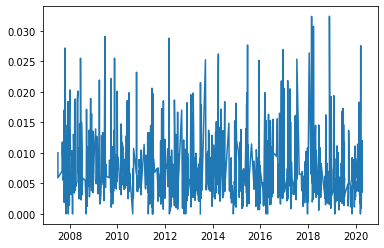

In [33]:
df['n_words'] = list(map(lambda x: len(words(x)), df['text']))
df['illegal_ratio'] = df['n_illegal_occurences']/df['n_words']
plt.plot(df['date'], df['illegal_ratio'])

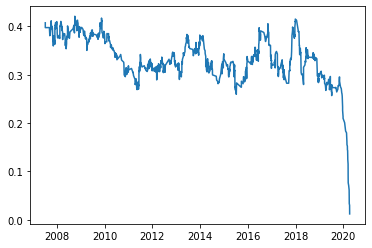

In [30]:
df.set_index('date')
# TODO: set rolling averege over time 
plt.plot(df['date'], df['illegal_ratio'].rolling(50, min_periods=1).sum())

In [47]:
df['url'][df['illegal_ratio'].argmax()]
df['url'][df['illegal_ratio'].argmin()]


'https://www.domstol.se/hogsta-domstolen/avgoranden/2019/30430/'